# The P-Median Problem

*Authors:* [Germano Barcelos](https://github.com/gegen07), [James Gaboardi](https://github.com/jGaboardi), [Levi J. Wolf](https://github.com/ljwolf), [Qunshan Zhao](https://github.com/qszhao)

Hakimi (1965) proposed this model thinking about locating telephone switching centers. The objective was to minimize the total length of wire serving all customers while locating $p$ telephone switching centers, assuming that each customer would be connected to the closest switching center. Here the objective is to _locate a fixed number of facilities such that the resulting sum of travel distances is minimized_.

**P-Median can be written as:**

$\begin{array} \displaystyle \textbf{Minimize} & \displaystyle \sum_{i \in I}\sum_{j \in J}{a_i d_{ij} X_{ij}} &&& (1) \\
\displaystyle \textbf{Subject to:} & \displaystyle \sum_{j \in J}{X_{ij} = 1} & \forall i \in I && (2) \\
            & \displaystyle \sum_{j \in J}{Y_{j} = p} &&& (3) \\
            & X_{ij} \leq Y_{j} & \forall i \in I & \forall j \in J & (4) \\
            & X_{ij} \in \{0,1\} & \forall i \in I & \forall j \in J & (5) \\
            & Y_{j} \in \{0,1\} & \forall j \in J && (6) \\ \end{array}$

$\begin{array} \displaystyle \textbf{Where:}\\ & & \displaystyle i & \small = & \textrm{index referencing nodes of the network as demand} \\
& & j & \small = & \textrm{index referencing nodes of the network as potential facility sites} \\
& & d_{ij} & \small = & \textrm{shortest distance or travel time between nodes } i \textrm{ and } j \\
& & p & \small = & \textrm{number of facilities to be located} \\
& & a_i & \small = & \textrm{service load or population demand at } i \\
& & X_{ij} & \small = & \begin{cases}
              1, \textrm{if demand } i \textrm{ is assigned to facility } j \\
              0, \textrm{otherwise}
           \end{cases} \\
& & Y_{j} & \small = & \begin{cases}
              1, \textrm{if node } j \textrm{ has been selected for a facility} \\
              0, \textrm{otherwise} \\
           \end{cases} \\ 
\end{array}$

_The formulation above is adapted from Church and Murray (2018)_

This tutorial generates synthetic demand (clients) and facility sites near a 10x10 lattice representing a gridded urban core.

* `PMedian.from_cost_matrix()` with network distance as the metric
* `PMedian.from_geodataframe()` with euclidean distance as the metric
* `PMedian.from_geodataframe()` with predefined facility locations and euclidean distance as the metric

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2025-04-07T15:08:04.849791-04:00

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit



In [2]:
import warnings

import geopandas
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy
import pulp
import shapely
from matplotlib.patches import Patch

import spopt
from spopt.locate import PMedian, simulated_geo_points

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/spaghetti#649
    import spaghetti

%watermark -w
%watermark -iv

Watermark: 2.5.0

numpy     : 2.2.4
geopandas : 1.0.1
shapely   : 2.1.0
spaghetti : 1.7.6
matplotlib: 3.10.1
pulp      : 2.8.0
spopt     : 0.6.2.dev3+g13ca45e



Since the model needs a cost matrix (distance, time, etc.) we should define some variables. First we will assign some the number of clients and facility locations, then the maximum service radius, followed by random seeds in order to reproduce the results. Finally, the solver, assigned below as `pulp.COIN_CMD`, is an interface to optimization solver developed by [COIN-OR](https://github.com/coin-or/Cbc). If you want to use another optimization interface, such as Gurobi or CPLEX, see this [guide](https://coin-or.github.io/pulp/guides/how_to_configure_solvers.html) that explains how to achieve this.

In [3]:
# quantity demand points
CLIENT_COUNT = 100

# quantity supply points
FACILITY_COUNT = 10

# number of candidate facilities in optimal solution
P_FACILITIES = 3

# random seeds for reproducibility
CLIENT_SEED = 5
FACILITY_SEED = 6

# set the solver
solver = pulp.COIN_CMD(msg=False, warmStart=True)

## Lattice 10x10

Create a 10x10 lattice with 9 interior lines, both vertical and horizontal.

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

Transform the `spaghetti` instance into a geodataframe.

In [5]:
streets = spaghetti.element_as_gdf(ntw, arcs=True)

In [6]:
streets_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(streets["geometry"].buffer(0.5).union_all()),
    crs=streets.crs,
    columns=["geometry"],
)

Plotting the network created by `spaghetti` we can verify that it mimics a district with quarters and streets.

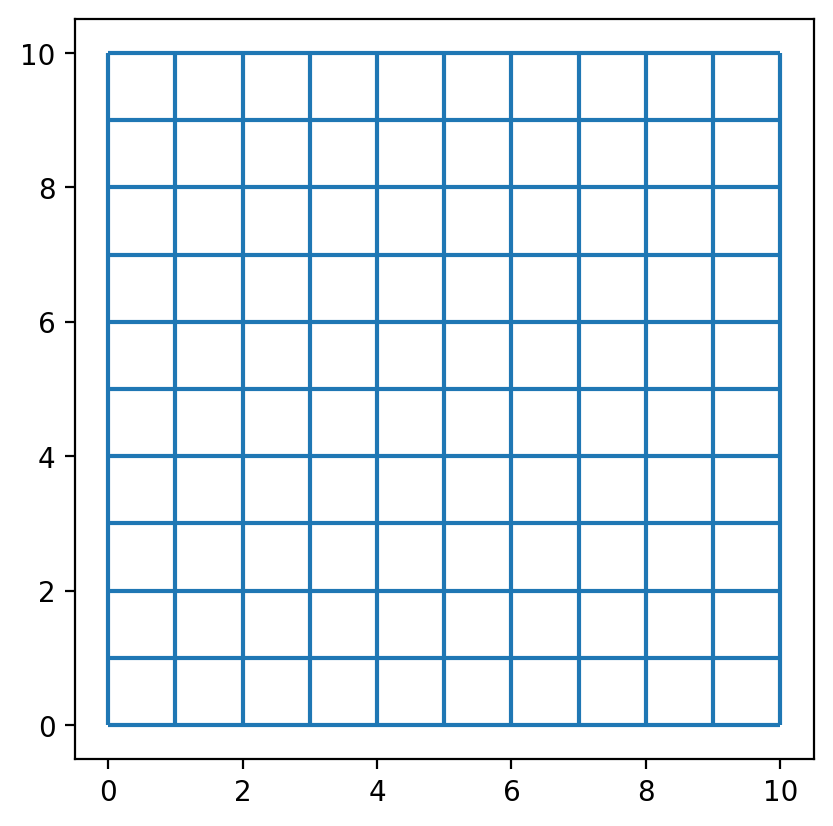

In [7]:
streets.plot();

## Simulate points in a network

The `simulated_geo_points` function simulates points near a network. In this case, it uses the 10x10 lattice network created using the `spaghetti` package. Below we use the function defined above and simulate the points near the lattice edges.

In [8]:
client_points = simulated_geo_points(
    streets_buffered, needed=CLIENT_COUNT, seed=CLIENT_SEED
)
facility_points = simulated_geo_points(
    streets_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

Plotting the 100 client and 10 facility points we can see that the function generates dummy points to an area of 10x10, which is the area created by our lattice created on previous cells.

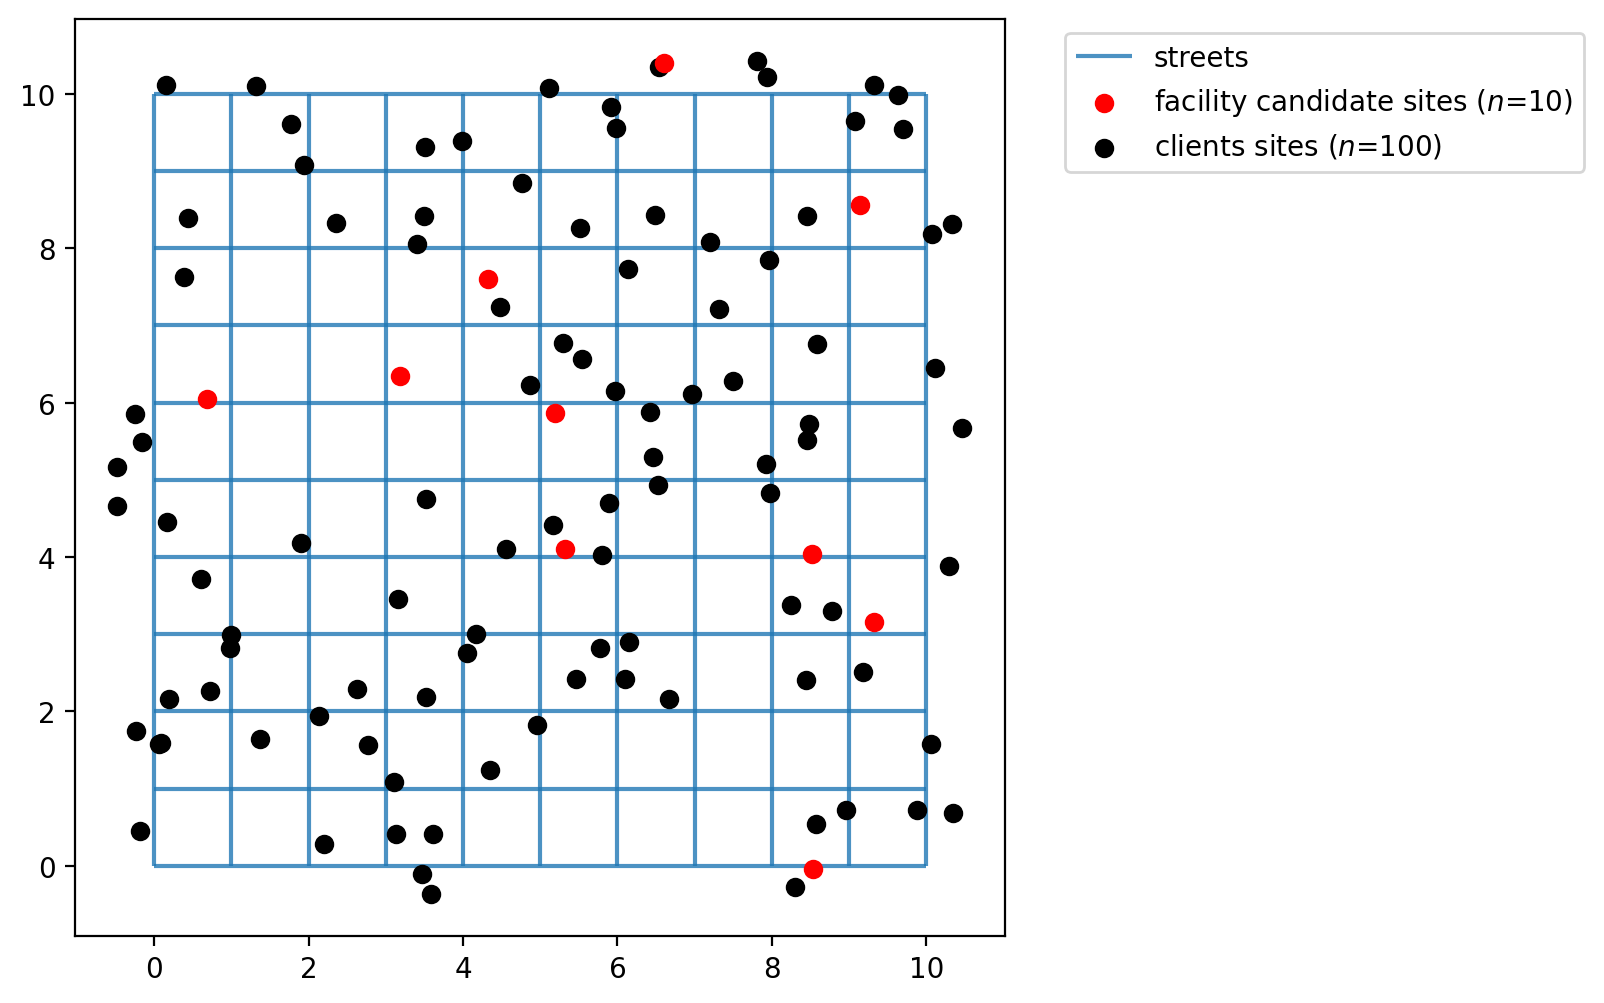

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
facility_points.plot(
    ax=ax,
    color="red",
    zorder=2,
    label=f"facility candidate sites ($n$={FACILITY_COUNT})",
)
client_points.plot(ax=ax, color="black", label=f"clients sites ($n$={CLIENT_COUNT})")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

For each client point the model supposes that there is a weight. So, we assign some random integers using `numpy` to simulate these weights. We will simulate weights in a range from a minimum of 1 and a maximum of 12.

In [10]:
numpy.random.seed(0)
ai = numpy.random.randint(1, 12, CLIENT_COUNT)
ai

array([ 6,  1,  4,  4,  8, 10,  4,  6,  3,  5,  8,  7,  9,  9, 11,  2,  7,
        8,  8,  9,  2,  6, 10,  9, 10,  5,  4,  1,  4,  6,  1,  3,  4,  9,
        2,  4,  4,  4,  8,  1,  2, 10, 10,  1, 11,  5,  8,  4,  3,  8,  3,
        1,  1,  5,  6,  6,  7,  9,  5,  2,  5, 10, 11, 11,  9,  2,  2,  8,
       10, 10,  4,  7,  8,  3,  1,  4,  6, 10, 11,  5,  5,  7,  5,  5,  4,
        5,  5,  9,  5,  4, 11,  8,  6,  6,  1,  2,  6, 10,  4,  1])

What's total the value of "weighted" clients?

In [11]:
client_points["weights"] = ai
client_points["weights"].sum()

np.int64(579)

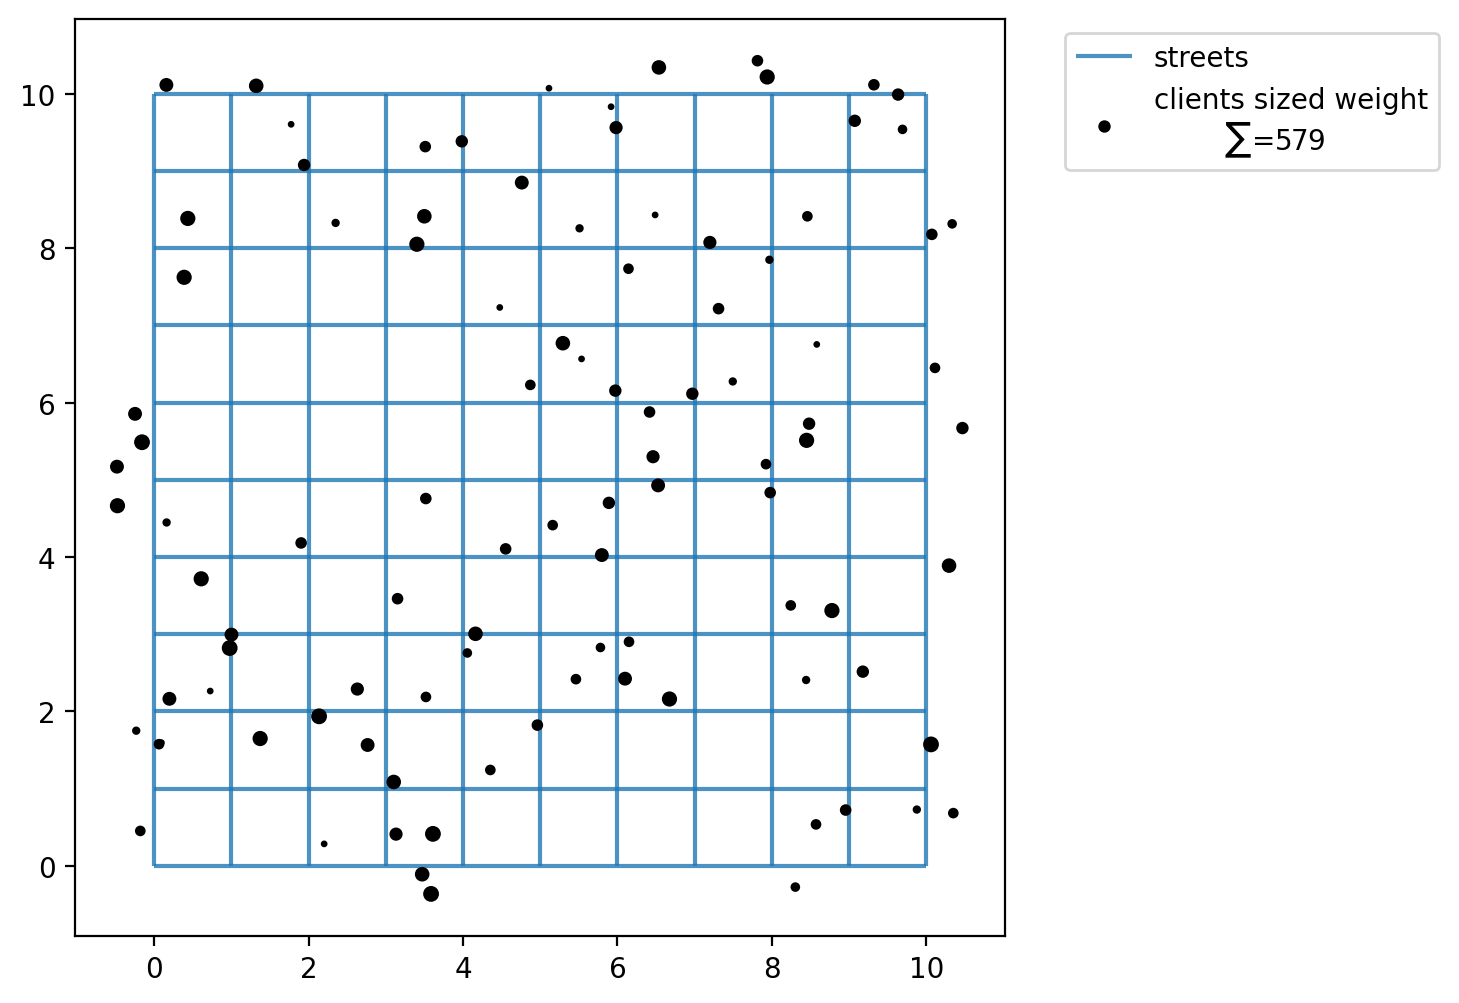

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
client_points.plot(
    ax=ax,
    color="black",
    label=f"clients sized weight\n\t$\\sum$={client_points['weights'].sum()}",
    markersize=ai * 2,
)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

## Assign simulated points network locations

The simulated client and facility points do not adhere to network space. Calculating distances between them without restricting movement to the network results in a euclidean distances,'as the crow flies.' While this is acceptable for some applications, for others it is more realistic to consider network traversal (e.g. Does a mail carrier follow roads to deliver letters or fly from mailbox to mailbox?).

In our first example we will consider distance along the 10x10 lattice network created above. Therefore, we must first snap the observation points to the network prior to calculating a cost matrix.

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    ntw.snapobservations(client_points, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(ntw, pp_name="clients", snapped=True)
clients_snapped.drop(columns=["id", "comp_label"], inplace=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(ntw, pp_name="facilities", snapped=True)
facilities_snapped.drop(columns=["id", "comp_label"], inplace=True)

Now the plot seems more organized as the points occupy network space. The network is plotted below with the network locations of the facility points and clients points.

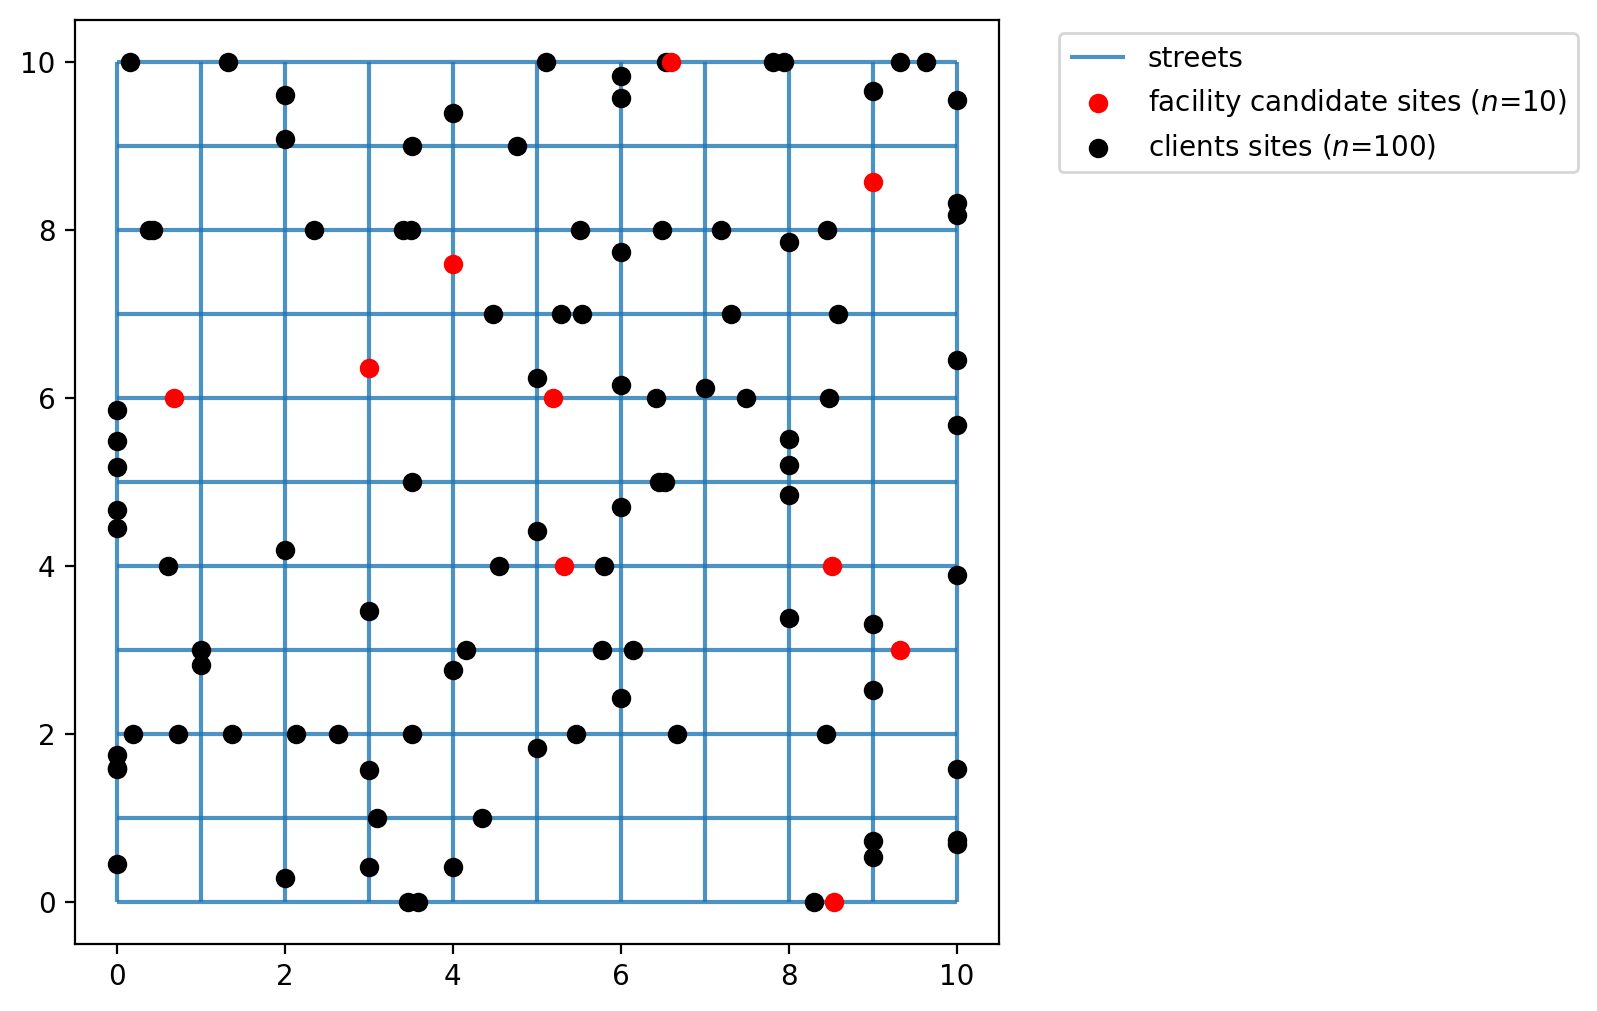

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
facilities_snapped.plot(
    ax=ax,
    color="red",
    zorder=2,
    label=f"facility candidate sites ($n$={FACILITY_COUNT})",
)
clients_snapped.plot(ax=ax, color="black", label=f"clients sites ($n$={CLIENT_COUNT})")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

## Calculating the (network distance) cost matrix
Calculate the network distance between clients and facilities.

In [15]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix.shape

(100, 10)

The expected result here is a network distance between clients and facilities points, in our case a 2D 100x10 array.

In [16]:
cost_matrix[:5, :]

array([[13.39951703, 15.61157572,  4.39383189,  8.40604635,  3.73034161,
         3.4833522 ,  6.2764559 ,  5.52085069, 11.59649553,  7.51670161],
       [13.92618165, 16.13824034,  4.92049651,  8.93271097,  4.25700623,
         4.01001682,  6.80312052,  4.99418607, 12.12316015,  8.04336623],
       [ 7.55064416,  9.76270285,  4.54495901,  2.55717348,  2.57689625,
         2.36552068,  0.42758302,  5.36972356,  5.74762266,  6.33217127],
       [ 3.52405953,  5.73611822,  8.11317865,  3.87460688,  6.14511589,
         6.3921053 ,  3.5990016 ,  6.19849608,  1.72103803,  4.35875589],
       [ 7.75652815,  7.09845387,  6.75084301,  4.76305747,  4.78278024,
         7.02976965,  6.63346702, 12.03397254,  7.95350665, 12.99642024]])

In [17]:
cost_matrix[-5:, :]

array([[ 4.82677859,  7.03883728,  6.8104596 ,  4.16669209,  4.84239683,
         5.08938625,  2.29628254,  4.89577702,  3.02375709,  4.06667068],
       [ 6.47650911,  8.6885678 ,  5.47082397,  2.82705646,  3.5027612 ,
         3.43965572,  0.95664692,  4.44385861,  4.67348761,  5.40630631],
       [10.9188216 , 13.13088029,  4.71841659,  5.92535092,  2.05492631,
         1.00265676,  3.79576046,  5.19626599,  9.1158001 ,  6.15871369],
       [ 3.17082521,  5.3828839 ,  8.46641298,  1.82264547,  6.49835021,
         6.74533963,  3.95223592,  7.74954251,  3.36780371,  8.4107173 ],
       [10.03753584,  6.81744618,  7.0318507 ,  7.04406516,  7.06378793,
         9.31077734,  8.91447471, 14.31498023, 10.23451434, 15.27742793]])

With ``PMedian.from_cost_matrix`` we model the $p$-median problem to minimize the total *weighted* cost between clients and $p$ facilities, 3 in our case, while ensuring that each client is assigned to one, and only one, facility. We use the network distance matrix calculated above (in generic 'distance units') to model cost.

In [18]:
pmedian_from_cm = PMedian.from_cost_matrix(
    cost_matrix, ai, p_facilities=P_FACILITIES, name="p-median-network-distance"
)

The expected result is a solved instance of `PMedian`.

In [19]:
pmedian_from_cm = pmedian_from_cm.solve(solver)
pmedian_from_cm

What's total and mean minimized weighted cost?

In [20]:
pmp_obj = round(pmedian_from_cm.problem.objective.value(), 3)
pmp_mean = round(pmedian_from_cm.mean_dist, 3)
print(
    f"A total minimized weighted distance of {pmp_obj} units is "
    f"observed, with a mean distance of {pmp_mean} per individual client."
)

A total minimized weighted distance of 2117.596 units is observed, with a mean distance of 3.657 per individual client.


Define the decision variable names used for mapping later.

In [21]:
facility_points["dv"] = pmedian_from_cm.fac_vars
facility_points["dv"] = facility_points["dv"].map(lambda x: x.name.replace("_", ""))
facilities_snapped["dv"] = facility_points["dv"]
facility_points

,geometry,dv
0,POINT (9.32146 3.15178),y0
1,POINT (8.53352 -0.04134),y1
2,POINT (0.68422 6.04557),y2
3,POINT (5.32799 4.10688),y3
4,POINT (3.18949 6.34771),y4
5,POINT (4.31956 7.5947),y5
6,POINT (5.1984 5.86744),y6
7,POINT (6.59891 10.39247),y7
8,POINT (8.51844 4.04521),y8
9,POINT (9.13894 8.56135),y9


## Calculating euclidean distance from a `GeoDataFrame`

With ``PMedian.from_cost_matrix`` we model the $p$-median problem to minimize the total *weighted* cost between clients and $p$ facilities, 3 in our case, while ensuring that each client is assigned to one, and only one, facility. Here we use geodataframes to calculate a euclidean distance cost matrix.

Next we will solve the $p$-median problem considering all 10 candidate locations for potential selection.

In [22]:
distance_metric = "euclidean"
clients_snapped["weights"] = client_points["weights"]
pmedian_from_gdf = PMedian.from_geodataframe(
    clients_snapped,
    facilities_snapped,
    "geometry",
    "geometry",
    "weights",
    p_facilities=P_FACILITIES,
    distance_metric=distance_metric,
    name=f"p-median-{distance_metric}-distance",
)

In [23]:
pmedian_from_gdf = pmedian_from_gdf.solve(solver)
pmp_obj = round(pmedian_from_gdf.problem.objective.value(), 3)
pmp_mean = round(pmedian_from_gdf.mean_dist, 3)
print(
    f"A total minimized weighted distance of {pmp_obj} units is "
    f"observed, with a mean distance of {pmp_mean} per individual client."
)

A total minimized weighted distance of 1642.918 units is observed, with a mean distance of 2.838 per individual client.


However, in many real world applications there may already be existing facility locations with the goal being to add one or more new facilities. Here we will define facilites $y_0$ and $y_1$ as already existing (they must be present in the model solution). This will lead to a sub-optimal solution.

***Important:*** The facilities in `"predefined_loc"` are a binary array where `1` means the associated location must appear in the solution.

In [24]:
facility_points["predefined_loc"] = 0
facility_points.loc[(0, 1), "predefined_loc"] = 1
facilities_snapped["predefined_loc"] = facility_points["predefined_loc"]
facility_points

,geometry,dv,predefined_loc
0,POINT (9.32146 3.15178),y0,1
1,POINT (8.53352 -0.04134),y1,1
2,POINT (0.68422 6.04557),y2,0
3,POINT (5.32799 4.10688),y3,0
4,POINT (3.18949 6.34771),y4,0
5,POINT (4.31956 7.5947),y5,0
6,POINT (5.1984 5.86744),y6,0
7,POINT (6.59891 10.39247),y7,0
8,POINT (8.51844 4.04521),y8,0
9,POINT (9.13894 8.56135),y9,0


In [25]:
pmedian_from_gdf_pre = PMedian.from_geodataframe(
    clients_snapped,
    facilities_snapped,
    "geometry",
    "geometry",
    "weights",
    p_facilities=P_FACILITIES,
    predefined_facility_col="predefined_loc",
    distance_metric=distance_metric,
    name=f"p-median-{distance_metric}-distance-predefined",
)

In [26]:
pmedian_from_gdf_pre = pmedian_from_gdf_pre.solve(solver)
pmp_obj = round(pmedian_from_gdf_pre.problem.objective.value(), 3)
pmp_mean = round(pmedian_from_gdf_pre.mean_dist, 3)
print(
    f"A total minimized weighted distance of {pmp_obj} units is "
    f"observed, with a mean distance of {pmp_mean} per individual client."
)

A total minimized weighted distance of 2080.805 units is observed, with a mean distance of 3.594 per individual client.


## Plotting the results

The two cells below describe the plotting of the results. For each method from the `PMedian` class (`.from_cost_matrix()`, `.from_geodataframe()`) there is a plot displaying the facility site that was selected with a star colored and the points covered with the same color.

In [27]:
dv_colors_arr = [
    "darkcyan",
    "mediumseagreen",
    "saddlebrown",
    "darkslategray",
    "lightskyblue",
    "thistle",
    "lavender",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
]
dv_colors = {f"y{i}": dv_colors_arr[i] for i in range(len(dv_colors_arr))}
dv_colors

{'y0': 'darkcyan',
 'y1': 'mediumseagreen',
 'y2': 'saddlebrown',
 'y3': 'darkslategray',
 'y4': 'lightskyblue',
 'y5': 'thistle',
 'y6': 'lavender',
 'y7': 'darkgoldenrod',
 'y8': 'peachpuff',
 'y9': 'coral',
 'y10': 'mediumvioletred',
 'y11': 'blueviolet',
 'y12': 'fuchsia',
 'y13': 'cyan',
 'y14': 'limegreen',
 'y15': 'mediumorchid'}

In [28]:
def plot_results(model, p, facs, clis=None, ax=None):
    """Visualize optimal solution sets and context."""
    if not ax:
        multi_plot = False
        fig, ax = plt.subplots(figsize=(6, 6))
        markersize, markersize_factor = 4, 4
    else:
        ax.axis("off")
        multi_plot = True
        markersize, markersize_factor = 2, 2
    ax.set_title(model.name, fontsize=15)

    # extract facility-client relationships for plotting (except for p-dispersion)
    plot_clis = isinstance(clis, geopandas.GeoDataFrame)
    if plot_clis:
        cli_points = {}
    fac_sites = {}
    for i, dv in enumerate(model.fac_vars):
        if dv.varValue:
            dv, predef = facs.loc[i, ["dv", "predefined_loc"]]
            fac_sites[dv] = [i, predef]
            if plot_clis:
                geom = clis.iloc[model.fac2cli[i]]["geometry"]
                cli_points[dv] = geom

    # study area and legend entries initialization
    streets.plot(ax=ax, alpha=1, color="black", zorder=1)
    legend_elements = [mlines.Line2D([], [], color="black", label="streets")]

    if plot_clis and model.name.startswith("mclp"):
        # any clients that not asscociated with a facility
        c = "k"
        if model.n_cli_uncov:
            idx = [i for i, v in enumerate(model.cli2fac) if len(v) == 0]
            pnt_kws = {
                "ax": ax,
                "fc": c,
                "ec": c,
                "marker": "s",
                "markersize": 7,
                "zorder": 2,
            }
            clis.iloc[idx].plot(**pnt_kws)
        _label = f"Demand sites not covered ($n$={model.n_cli_uncov})"
        _mkws = {
            "marker": "s",
            "markerfacecolor": c,
            "markeredgecolor": c,
            "linewidth": 0,
        }
        legend_elements.append(mlines.Line2D([], [], ms=3, label=_label, **_mkws))

    # all candidate facilities
    facs.plot(ax=ax, fc="brown", marker="*", markersize=80, zorder=8)
    _label = f"Facility sites ($n$={len(model.fac_vars)})"
    _mkws = {"marker": "*", "markerfacecolor": "brown", "markeredgecolor": "brown"}
    legend_elements.append(mlines.Line2D([], [], ms=7, lw=0, label=_label, **_mkws))

    # facility-(client) symbology and legend entries
    zorder = 4
    for fname, (fac, predef) in fac_sites.items():
        cset = dv_colors[fname]
        if plot_clis:
            # clients
            geoms = cli_points[fname]
            gdf = geopandas.GeoDataFrame(geoms)
            gdf.plot(ax=ax, zorder=zorder, ec="k", fc=cset, markersize=100 * markersize)
            _label = f"Demand sites covered by {fname}"
            _mkws = {
                "markerfacecolor": cset,
                "markeredgecolor": "k",
                "ms": markersize + 7,
            }
            legend_elements.append(
                mlines.Line2D([], [], marker="o", lw=0, label=_label, **_mkws)
            )
        # facilities
        ec = "k"
        lw = 2
        predef_label = "predefined"
        if model.name.endswith(predef_label) and predef:
            ec = "r"
            lw = 3
            fname += f" ({predef_label})"
        facs.iloc[[fac]].plot(
            ax=ax, marker="*", markersize=1000, zorder=9, fc=cset, ec=ec, lw=lw
        )
        _mkws = {"markerfacecolor": cset, "markeredgecolor": ec, "markeredgewidth": lw}
        legend_elements.append(
            mlines.Line2D([], [], marker="*", ms=20, lw=0, label=fname, **_mkws)
        )
        # increment zorder up and markersize down for stacked client symbology
        zorder += 1
        if plot_clis:
            markersize -= markersize_factor / p

    if not multi_plot:
        # legend
        kws = {"loc": "upper left", "bbox_to_anchor": (1.05, 0.7)}
        plt.legend(handles=legend_elements, **kws)

### P-Median built from cost matrix (network distance)

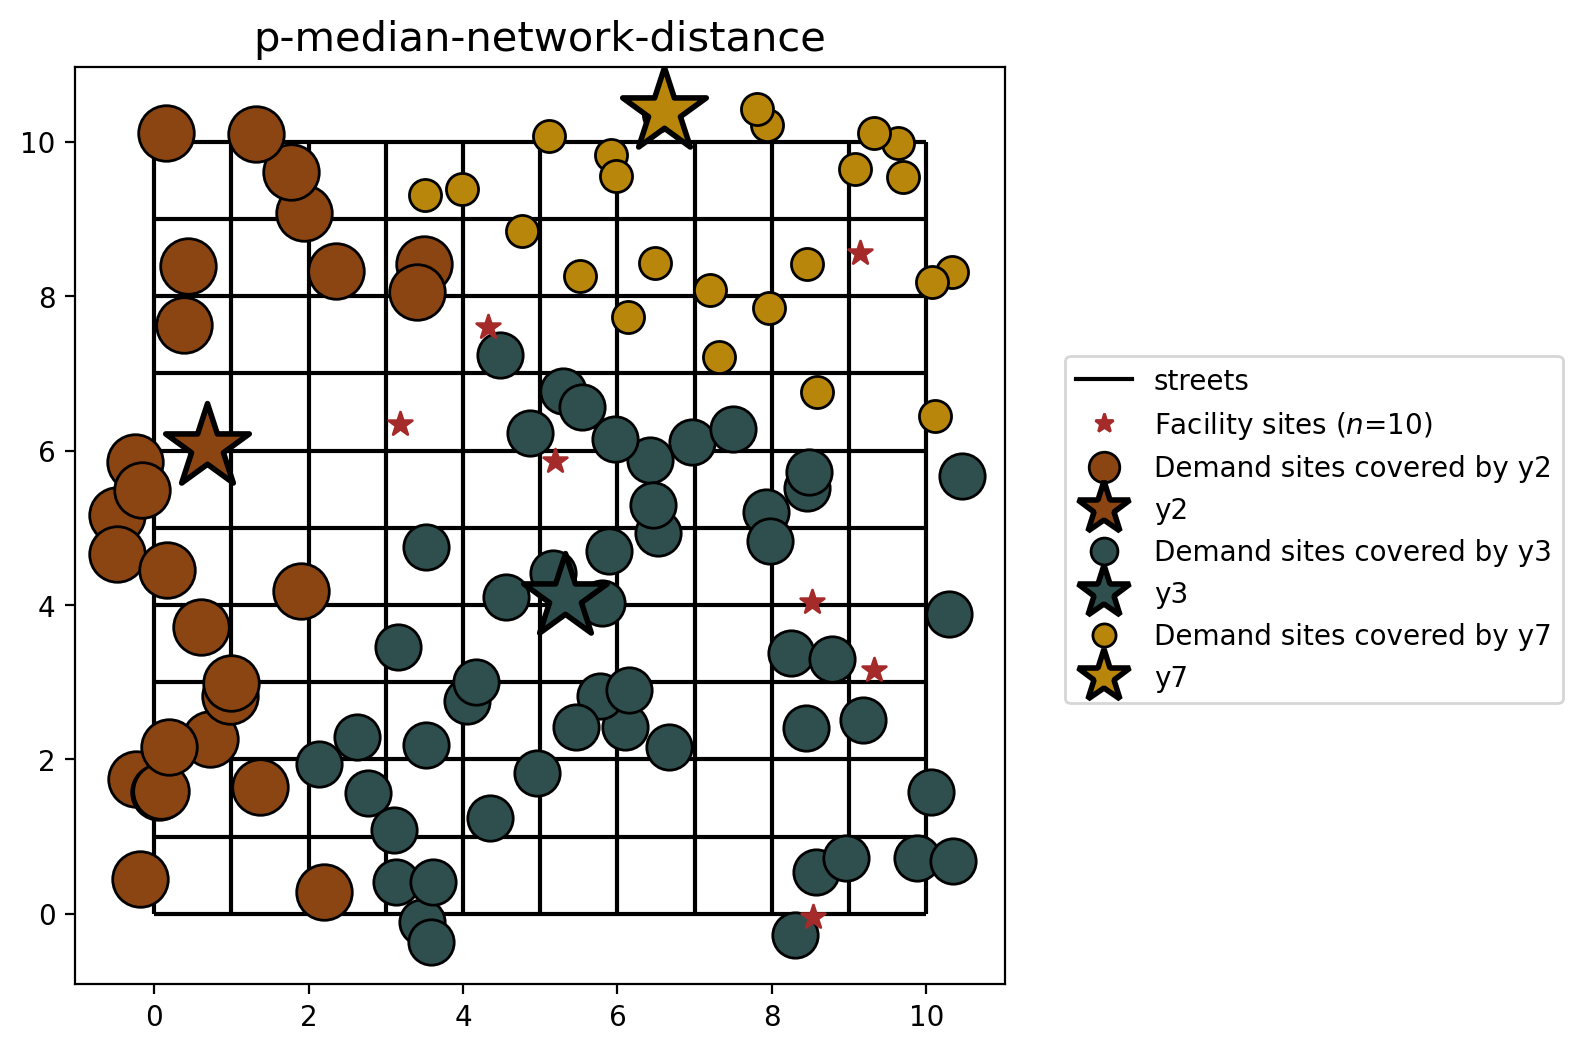

In [29]:
plot_results(pmedian_from_cm, P_FACILITIES, facility_points, clis=client_points)

### P-median built from geodataframes (euclidean distance)

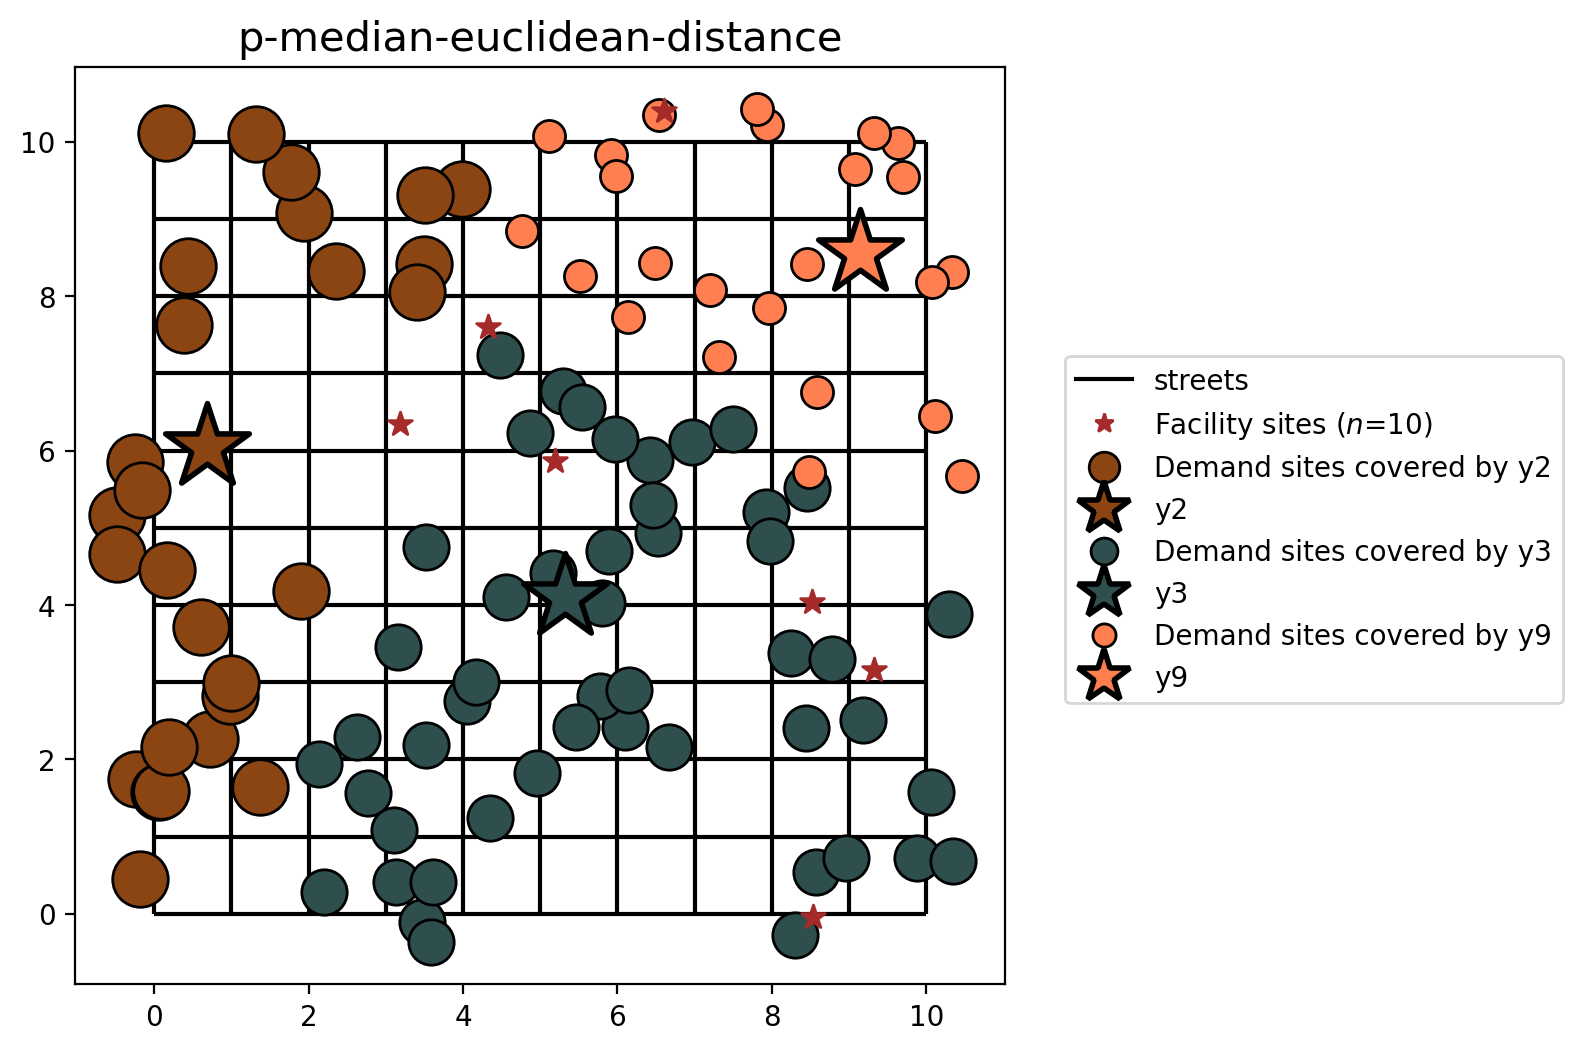

In [30]:
plot_results(pmedian_from_gdf, P_FACILITIES, facility_points, clis=client_points)

You may notice that the model results are similar, yet different. This is expected as the distances between facility and demand points are calculated with different metrics (network vs. euclidean distance).

### P-median with preselected facilities (euclidean distance)

Finally, let's visualize the results of the $p$-median problem when stipulating that facilities $y_0$ and $y_1$ must be included in the final selection.

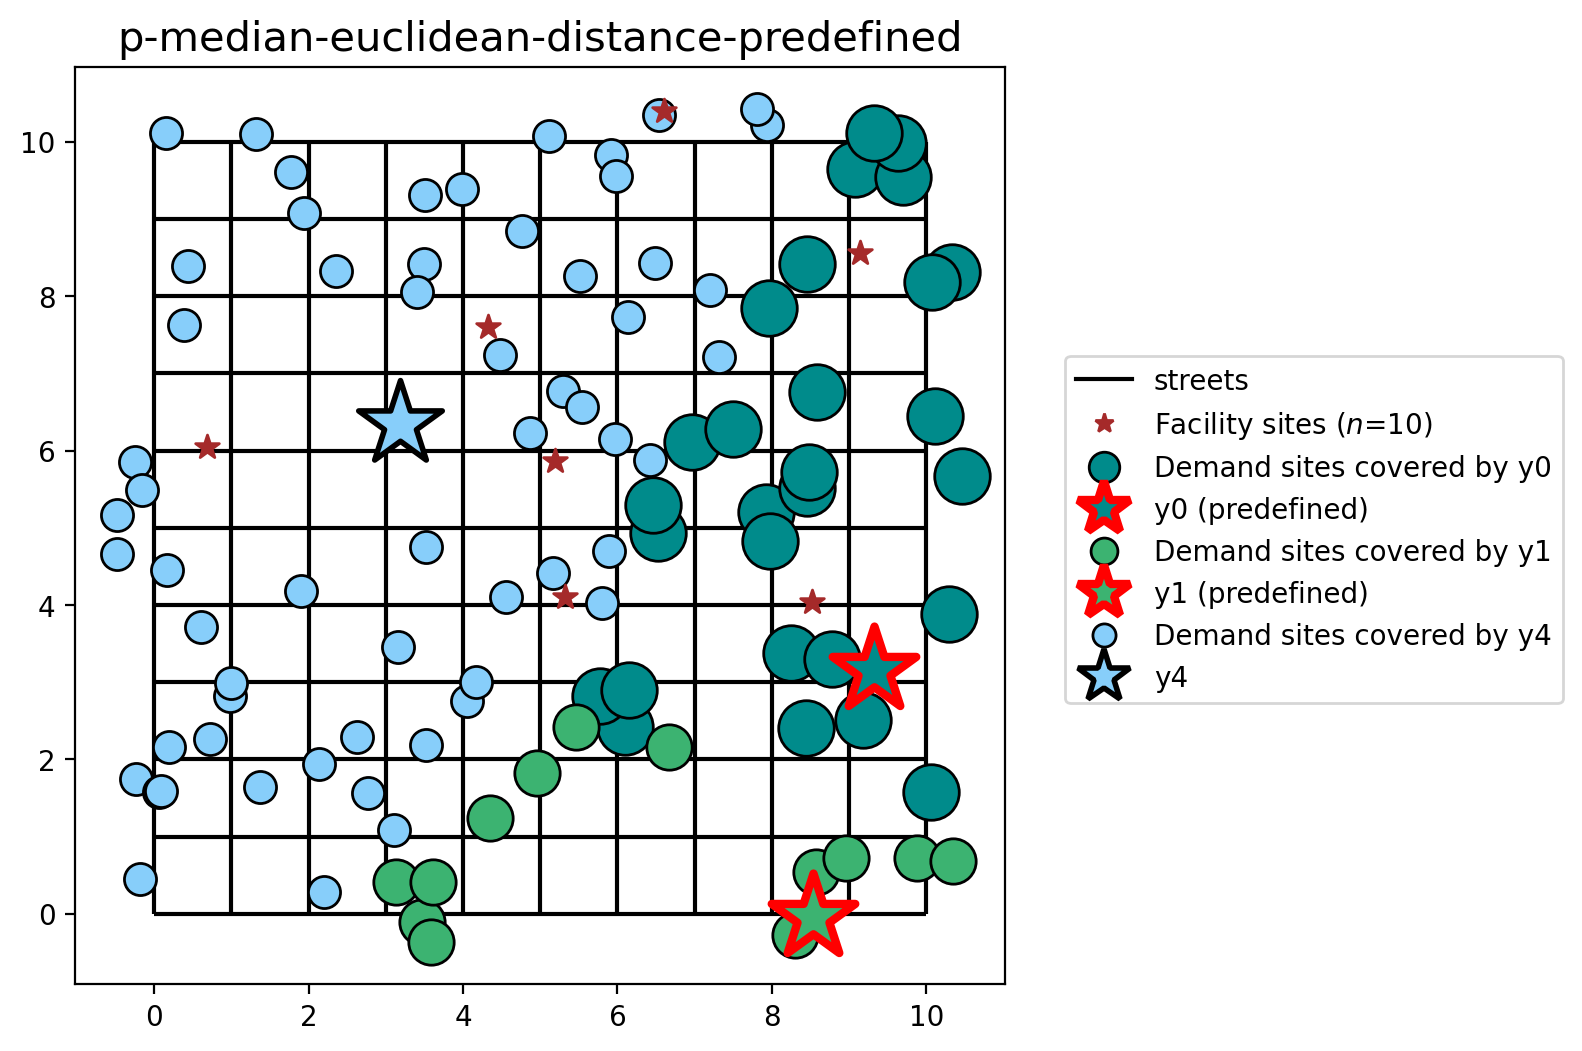

In [31]:
plot_results(pmedian_from_gdf_pre, P_FACILITIES, facility_points, clis=client_points)

Here, the differences is explained by the preselected facilities $y_0$ and $y_1$. So, the $p$-median model chooses the facility $y_4$ to minimize the total weighted cost to serve all clients.

-----------------------------------

## Comparing solution from varied metrics

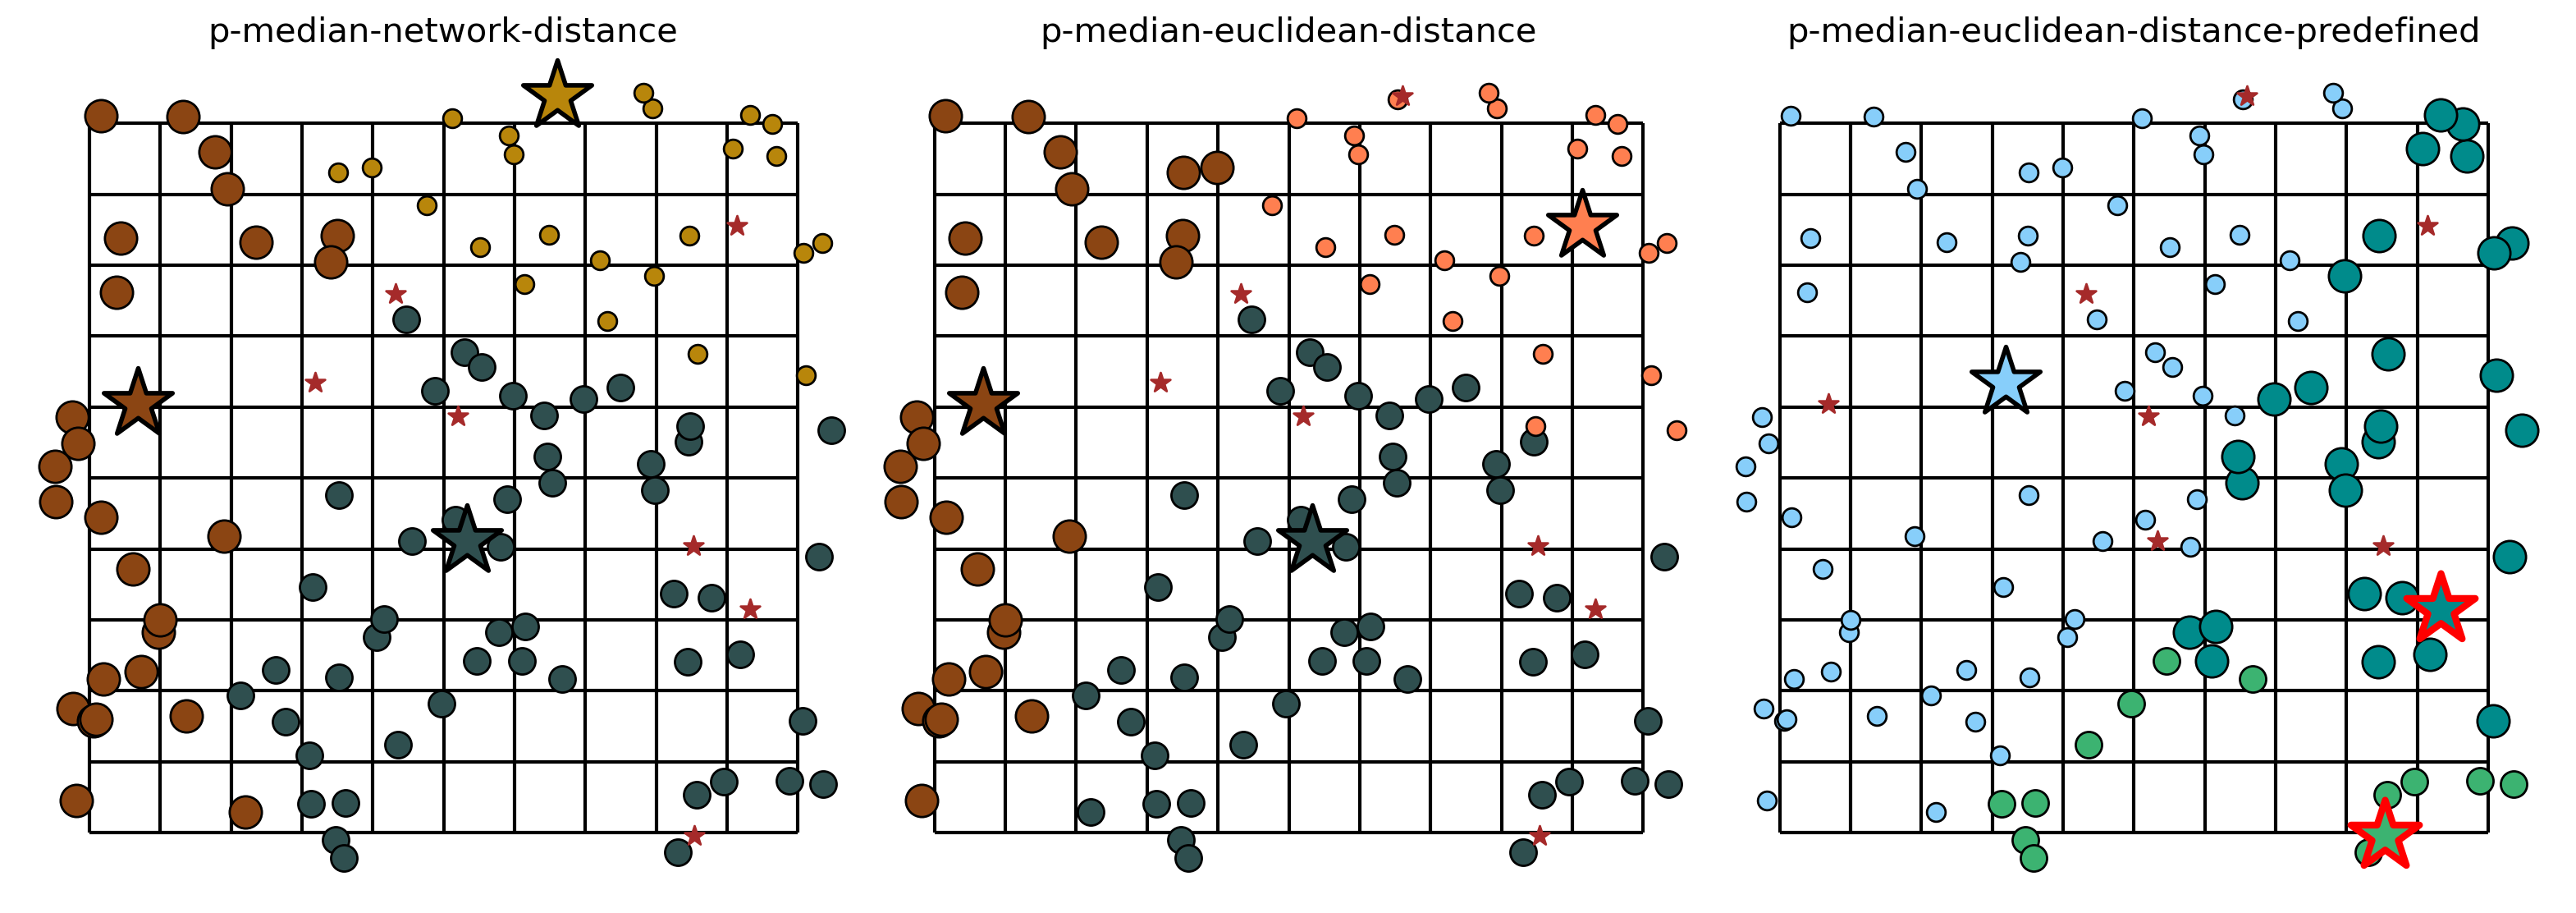

In [32]:
fig, axarr = plt.subplots(1, 3, figsize=(20, 10))
fig.subplots_adjust(wspace=-0.01)
for i, m in enumerate([pmedian_from_cm, pmedian_from_gdf, pmedian_from_gdf_pre]):
    plot_results(m, P_FACILITIES, facility_points, clis=client_points, ax=axarr[i])

## Capacitated p-median problem

Based on the classic p-median problem, we further consider the location allocation problem with the facility's capacity, and the amount of demand at the demand point. Therefore, we add new functions to `p-median` function of `spopt`, to solve this type of problem.   

**Capacitated P-Median can be written as:**

$\begin{array} \displaystyle \textbf{Minimize} & \displaystyle \sum_{i \in I}\sum_{j \in J}{a_i d_{ij} X_{ij}} &&& (1) \\
\displaystyle \textbf{Subject to:} & \displaystyle \sum_{j \in J}{X_{ij} = 1} & \forall i \in I && (2) \\
            & \displaystyle \sum_{j \in J}{Y_{j} = p} &&& (3) \\
            & \displaystyle \sum_{i \in I}{a_i X_{ij} \leq {c_j Y_{j}}}& \forall j \in J && (4) \\
            & X_{ij} \leq Y_{j} & \forall i \in I & \forall j \in J & (5) \\
            & X_{ij} \in \{0,1\} & \forall i \in I & \forall j \in J & (6) \\
            & Y_{j} \in \{0,1\} & \forall j \in J && (7) \\ \end{array}$

$\begin{array} \displaystyle \textbf{Where:}\\ & & \displaystyle i & \small = & \textrm{index referencing nodes of the network as demand} \\
& & j & \small = & \textrm{index referencing nodes of the network as potential facility sites} \\
& & d_{ij} & \small = & \textrm{shortest distance or travel time between nodes } i \textrm{ and } j \\
& & p & \small = & \textrm{number of facilities to be located} \\
& & a_i & \small = & \textrm{service load or population demand at } i \\
& & c_j & \small = & \textrm{capacity of facility} j \\
& & X_{ij} & \small = & \begin{cases}
              1, \textrm{if demand } i \textrm{ is assigned to facility } j \\
              0, \textrm{otherwise}
           \end{cases} \\
& & Y_{j} & \small = & \begin{cases}
              1, \textrm{if node } j \textrm{ has been selected for a facility} \\
              0, \textrm{otherwise} \\
           \end{cases} \\ 
\end{array}$

_The formulation above is adapted from Church and Murray (2009)_

In the previous p-median problem, we have the demand value of each client point, which is the 'weight'. And in that condition, we acutally assume that the capacity of each facility is infinite. Now we can make this model more realisitic by considering the capacity.   

Again, we would take the p-median case with network distance as the example, to introduce how to achieve the capacity constraint by using the `facility_capacities` function.

Firstly, we need to create the facility's capacity, by assigning some random integers using `numpy` to simulate these values. We will simulate capacity in a range from a minimum of 60 and a maximum of 120.

In [33]:
numpy.random.seed(1)
cj = numpy.random.randint(60, 120, FACILITY_COUNT)
cj

array([ 97, 103,  72,  68,  69,  71,  65,  75,  60,  76])

In [34]:
facility_points["capacity"] = cj
facility_points["capacity"].sum()

np.int64(756)

The sum of the facility capacity is 756, which is more than the total amount of demand, 579. It means the 10 facilities can accommodate all the demand.   

It also means we need to increase the number of candidate facilities in the final optimal solution, because the capacity is limited.

In [35]:
pmedian_capacity_from_cm = PMedian.from_cost_matrix(
    cost_matrix,
    ai,
    p_facilities=8,
    facility_capacities=cj,
    name="p-median-network-distance",
)

In [36]:
pmedian_capacity_from_cm = pmedian_capacity_from_cm.solve(solver)
pmedian_capacity_from_cm

How many facilities are allocated? And how many clients will they serve?

In [37]:
for fac, cli in enumerate(pmedian_capacity_from_cm.fac2cli):
    if len(cli) > 0:
        print(f"facility {fac} serving {len(cli)} clients")

facility 1 serving 16 clients
facility 2 serving 11 clients
facility 3 serving 14 clients
facility 4 serving 10 clients
facility 5 serving 10 clients
facility 6 serving 14 clients
facility 7 serving 14 clients
facility 8 serving 11 clients


### Capacitated p-median problem with preselected facilities

In many real world applications there may already be existing facility locations with the goal being to add one or more new facilities. Here we will define facilites $y_0$ and $y_1$ as already existing (they must be present in the model solution). This will lead to a sub-optimal solution. 

In the context of the capacitated p-median problem in `spopt`, it's also possible to consider facilities that have already been chosen beforehand. 

***Important:*** When using the `from_cost_matrix` method to solve capacitated p-median problem with preselected facilities, it is necessary for the user to supply a NumPy array as the `predefined_facilities_arr` parameter. This parameter represents the array of predefined facilities that are required to be included in the solution.

In [38]:
predefine = numpy.array([0, 1])
pmedian_capacity_predefined_from_cm = PMedian.from_cost_matrix(
    cost_matrix,
    ai,
    p_facilities=8,
    facility_capacities=cj,
    predefined_facilities_arr=predefine,
    name="p-median-predefined-facilities-network-distance",
)
pmedian_capacity_predefined_from_cm = pmedian_capacity_predefined_from_cm.solve(solver)

In [39]:
for fac, cli in enumerate(pmedian_capacity_predefined_from_cm.fac2cli):
    if len(cli) > 0:
        print(f"facility {fac} serving {len(cli)} clients")

facility 0 serving 14 clients
facility 1 serving 12 clients
facility 2 serving 11 clients
facility 3 serving 14 clients
facility 4 serving 10 clients
facility 5 serving 11 clients
facility 6 serving 14 clients
facility 7 serving 14 clients


From the result, in total 8 facilities are allocated, and $y_0$ and $y_1$ are two of them.   

One more new function about preselected facilities, is that you can choose whether to fulfill its capacity. For example, the capacity of $y_0$ is 97, and you wish to assign 97 demand value to it. It sometimes happens when you need to meet specific facility requirements.   

The function name is `fulfill_predefined_fac`. Here is the example of how to use it.

In [40]:
pmedian_capacity_fulfill_predefined_from_cm = PMedian.from_cost_matrix(
    cost_matrix,
    ai,
    p_facilities=8,
    facility_capacities=cj,
    predefined_facilities_arr=predefine,
    fulfill_predefined_fac=True,
    name="p-median-fulfill-predefined-facilities-network-distance",
)
pmedian_capacity_fulfill_predefined_from_cm = (
    pmedian_capacity_fulfill_predefined_from_cm.solve(solver)
)

In [41]:
for fac, cli in enumerate(pmedian_capacity_fulfill_predefined_from_cm.fac2cli):
    if len(cli) > 0:
        print(f"facility {fac} serving {len(cli)} clients")

facility 0 serving 15 clients
facility 1 serving 19 clients
facility 2 serving 10 clients
facility 3 serving 10 clients
facility 5 serving 13 clients
facility 6 serving 12 clients
facility 7 serving 9 clients
facility 9 serving 12 clients


From the result, we can see that the number of clients they will serve is different. Because we set the constraint to fulfill the capacity of preselected facilities, we get the different solutions.

## References

- [Hakimi, S. L. (1965). Optimum Distribution of Switching Centers in a Communication Network and Some Related Graph Theoretic Problems. Operations Research, 13(3), 462–475.](https://doi:10.1287/opre.13.3.462) 

- [Church, R. L., & Murray, A. T. (2009). Business site selection, location analysis, and GIS (pp. 209-233). Hoboken, NJ: John Wiley & Sons.](http://ndl.ethernet.edu.et/bitstream/123456789/22145/1/45.pdf)

- [Church, R. L., & Murray, A. T. (2018). Location covering models: History, applications and advancements (1st edition 2018). Springer](https://www.springer.com/gb/book/9783319998459)